PAD Project

# Zbieranie i Czyszczenie danych

In [448]:
import pandas as pd
import re

sf_df = pd.read_csv("matchinfo.csv", sep=',')
df = pd.DataFrame(sf_df)
dfM = df.drop(df.iloc[:, 9:30], axis=1)
dfTb = dfM[['blueTeamTag', 'bResult']].copy()
dfTb = dfTb.groupby(['blueTeamTag'])['bResult'].count().reset_index(name = "wins")
dfTr = dfM[['redTeamTag', 'rResult']].copy()

dfTr = dfTr.groupby(['redTeamTag'])['rResult'].count().reset_index(name = "wins")
dfT = pd.merge(dfTb,dfTr, left_on='blueTeamTag', right_on='redTeamTag', how='outer')
if(dfT['blueTeamTag'].equals(dfT['redTeamTag'])):
    dfT['Tag'] = dfT['blueTeamTag']
else:
    dfT['Tag'] = dfT['redTeamTag']
dfT['Wins'] = dfT['wins_x'].fillna(0) + dfT['wins_y'].fillna(0)

dfM['Side'] = dfM['bResult'].apply(lambda x: 'Blue' if x > 0 else 'Red')
dfM['Result'] = dfM.apply(lambda x: 1 if x.Side == 'Blue' else 0, axis=1)
dfM.rename(columns={'blueTeamTag':'BlueTeamTag', 'redTeamTag':'RedTeamTag', 'gamelength': 'Gamelength', 'bResult': 'BResult', 'rResult':'RResult'}, inplace=True)
dfT
dfM.to_csv('data.csv', sep=',', encoding='utf-8')
dfT.to_csv('teams.csv', sep=',', encoding='utf-8')
dfM

,League,Year,Season,Type,BlueTeamTag,BResult,RResult,RedTeamTag,Gamelength,Side,Result
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,Blue,1
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,Red,0
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,Blue,1
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,Red,0
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,Blue,1
...,...,...,...,...,...,...,...,...,...,...,...
7615,TCL,2018,Spring,Season,YC,0,1,SUP,34,Red,0
7616,TCL,2018,Spring,Season,GAL,0,1,DP,39,Red,0
7617,OPL,2018,Spring,Season,SIN,0,1,DW,24,Red,0
7618,OPL,2018,Spring,Season,LGC,1,0,TTC,35,Blue,1


# Analiza danych 
# Wnioski
- Widoczna tendencja większej ilości rozegranych gier każdego typu w kolejnych latach
- Tendencja większej ilości wygranych dla drużyn po stronie niebieskiej
- Czas gry również przyczynia się do częstrzej wygranej dla drużyny niebieskiej
- Brak większych wahań wygrania konkretnej strony dla poszczególnych lig na przestrzeni lat, z niewielkimi wyjątkami dla CSL, EULCS, TCL w 2018 roku
- W tabeli pivot widać przełożenie, że im dłuższy czas tym większe prawdopodobieństwo wygrania strony niebieskiej
- Równy rozkład wygrania poszczególnych stron na przestrzeni lat


In [446]:
figOne = px.histogram(dfM, "Year", color="Type")
figOne.update_yaxes(matches=None, showticklabels=True)

Wykres pokazujący liczbę gier danego typu na przestrzeni lat

In [382]:
import plotly.express as px

fig = px.histogram(dfT, "Tag", "Wins" ,title="Victories by Team")
fig.show()

Wykres dotyczący ilości wygranych danej drużyny we wszsytkich mistrzostwach 

In [413]:
fig2 = px.histogram(dfM, 'Side',title="Victories by Side", color='Side', width=500)
fig2.show()

Zwycięstwa na podstawie strony drużyny wygranej

In [435]:
fig3 = px.pie(dfM, values='Gamelength', names='Side',title="Victories by Side and Time", color='Side', width=500)
fig3.show()

Procentowa wygrana obu stron na postawie czasu gry

In [406]:
league_df = dfM.pivot_table('Result', 'League', 'Year')
px.imshow(league_df, title="Winning Side in Leagues and Years", width=600, height=550)

Diagram ciepła pokazujący liczbę zwycięstw na podstawie strony na wszystkich mistrzostwach w kolejnych latach

In [411]:
length_df = dfM.pivot_table('Result', 'Gamelength', 'League')
px.imshow(length_df, title="Winning Side by Game length", width=600, height=550)

Diagram ciepła pokazujący wygraną stronę na podstawie czasu gry

In [423]:
Blue_df = dfM.pivot_table('Result', 'Year', 'BlueTeamTag')
px.imshow(Blue_df, title="Winning Team Blue in Years", width=800, height=350)

Diagram Ciepła pokazujący wygrane drużyn po stronie niebieskich w latach

In [424]:
Red_df = dfM.pivot_table('Result', 'Year', 'RedTeamTag')
px.imshow(Red_df, title="Winning Team Red in Years", width=800, height=350)

Diagram Ciepła pokazujący wygrane drużyn po stronie czerwonych w latach

# Uczenie maszynowe
Model klasyfikacyjny za pomocą biblioteki sklearn

In [478]:
machine_df = dfM.copy()
machine_df['Season_m'] = dfM['Season'].astype('category').cat.codes
machine_df['RTeam_m'] = dfM['RedTeamTag'].astype('category').cat.codes
machine_df['Type_m'] = dfM['Type'].astype('category').cat.codes
machine_df['Gamelength_m'] = dfM['Gamelength'].astype('category').cat.codes
machine_df.columns = machine_df.columns.to_series().apply(lambda x: x.strip())
machine_df


,League,Year,Season,Type,BlueTeamTag,BResult,RResult,RedTeamTag,Gamelength,Side,Result,Season_m,RTeam_m,Type_m,Gamelength_m
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,Blue,1,0,25,4,23
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,Red,0,0,51,4,21
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,Blue,1,0,88,4,23
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,Red,0,0,204,4,24
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,Blue,1,0,201,4,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7615,TCL,2018,Spring,Season,YC,0,1,SUP,34,Red,0,0,199,4,17
7616,TCL,2018,Spring,Season,GAL,0,1,DP,39,Red,0,0,53,4,22
7617,OPL,2018,Spring,Season,SIN,0,1,DW,24,Red,0,0,54,4,7
7618,OPL,2018,Spring,Season,LGC,1,0,TTC,35,Blue,1,0,215,4,18


Stworzenie modelu do testowania przy n-estymatorach = 60 oraz rozmiarze testu 0.1

In [497]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

predictors = ['Type_m', 'Season_m', 'RTeam_m', 'Gamelength_m']
model = RandomForestClassifier(n_estimators=60, min_samples_split=15, random_state=1)
train, test = train_test_split(machine_df, test_size=0.1)
model.fit(train[predictors], train['Result'])

RandomForestClassifier(min_samples_split=15, n_estimators=60, random_state=1)

Testowanie modelu

In [510]:
from sklearn.metrics import accuracy_score

predict = model.predict(test[predictors])
accuracy = accuracy_score(test['Result'], predict)

print(accuracy)

0.5669291338582677


Wynik testowania z celnością około 0.57

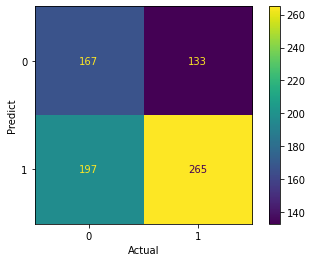

In [511]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(predict, test['Result'])
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.plot()
plt.show()

Wykres pokazujący ilość dobrze oraz źle zaklasyfikowanych porażek oraz zwycięstw dla konkretnych stron